In [2]:
# Copyright (c) MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# 3D Latent Diffusion Model
In this tutorial, we will walk through the process of using the MONAI Generative Models package to generate synthetic data using Latent Diffusion Models (LDM)  [1, 2]. Specifically, we will focus on training an LDM to create synthetic brain images from the Brats dataset.

[1] - Rombach et al. "High-Resolution Image Synthesis with Latent Diffusion Models" https://arxiv.org/abs/2112.10752

[2] - Pinaya et al. "Brain imaging generation with latent diffusion models" https://arxiv.org/abs/2209.07162

### Set up imports

In [3]:
import os
import shutil
import tempfile

import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from monai import transforms
from monai.apps import DecathlonDataset
from monai.config import print_config
from monai.data import DataLoader
from monai.utils import first, set_determinism
from torch.cuda.amp import GradScaler, autocast
from torch.nn import L1Loss
from tqdm import tqdm

from generative.inferers import LatentDiffusionInferer
from generative.losses import PatchAdversarialLoss, PerceptualLoss
from generative.networks.nets import AutoencoderKL, DiffusionModelUNet, PatchDiscriminator
from generative.networks.schedulers import DDPMScheduler

print_config()

MONAI version: 1.3.0
Numpy version: 1.26.4
Pytorch version: 2.3.1+cu121
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 865972f7a791bf7b42efbcd87c8402bd865b329e
MONAI __file__: /home/<username>/Documents/ct-images-augmentation/.venv/lib/python3.10/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.2.1
scikit-image version: 0.24.0
scipy version: 1.14.0
Pillow version: 10.3.0
Tensorboard version: 2.17.0
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.18.1+cu121
tqdm version: 4.66.4
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.8
pandas version: 2.2.2
einops version: 0.8.0
transformers version: 4.40.2
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about installin

In [4]:
# for reproducibility purposes set a seed
set_determinism(42)

### Setup a data directory and download dataset
Specify a MONAI_DATA_DIRECTORY variable, where the data will be downloaded. If not specified a temporary directory will be used.

### Prepare data loader for the training set
Here we will download the Brats dataset using MONAI's `DecathlonDataset` class, and we prepare the data loader for the training set.

In [5]:
from src.dataset import load_dataset, DatasetConfig

In [6]:
ds_config = DatasetConfig(
    path = "/ravana/d3d_work/micorl/data/ct_images_prostate_32fixed",
    image_size=128
)

In [7]:
# ds = load_dataset("/ravana/d3d_work/micorl/data/ct_images_prostate_32fixed/")
ds = load_dataset(ds_config)

Caching to disk


In [8]:
batch_size = 1
channel = 0  # 0 = Flair

In [9]:
train_loader = DataLoader(
            ds,
            batch_size=batch_size,
            num_workers=8,
            shuffle=True,
            pin_memory=torch.cuda.is_available(),
        )

### Visualise examples from the training set

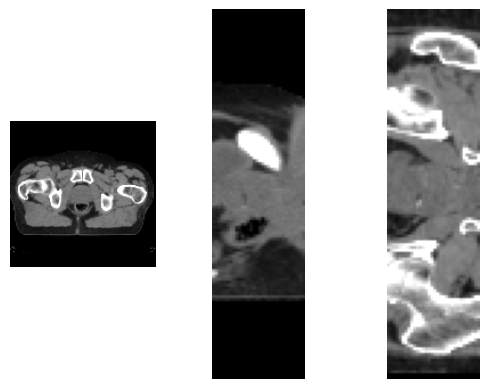

In [172]:
# Plot axial, coronal and sagittal slices of a training sample
check_data = first(train_loader)
idx = 0

img = check_data[idx, 0]
fig, axs = plt.subplots(nrows=1, ncols=3)
for ax in axs:
    ax.axis("off")
ax = axs[0]
ax.imshow(img[..., img.shape[2] // 2], cmap="gray")
ax = axs[1]
ax.imshow(img[:, img.shape[1] // 2, ...], cmap="gray")
ax = axs[2]
ax.imshow(img[img.shape[0] // 2, ...], cmap="gray")
# plt.savefig("training_examples.png")

In [20]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using {device}")

Using cuda:0


In [60]:
# from src.models.monai_autoencoder import GAN

from src.models.monai_autoencoder import GAN

In [189]:
vae = GAN.load_from_checkpoint("../models/monai_autoencoder/checkpoints/monai_autoencoder-v5.ckpt", map_location=device).eval()

/home/gormat/Documents/ct-images-augmentation/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/gormat/Documents/ct-images-augmentation/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_1_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_1_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [152]:
vae = vae.to(device)

In [173]:
check_data.shape

torch.Size([1, 1, 128, 128, 32])

In [174]:
from src.utils import dicom_batch_to_video_batch, video_batch_to_dicom_batch

In [175]:
x = dicom_batch_to_video_batch(check_data).to(device)

In [176]:
# x.to("cuda:1").device

In [177]:
check_data.shape

torch.Size([1, 1, 128, 128, 32])

In [190]:
# from tabnanny import check


# x.shape
check_data.shape

torch.Size([1, 1, 128, 128, 32])

In [191]:
with torch.no_grad():
    with autocast(enabled=True):
        # z = autoencoder.encode_stage_2_inputs(check_data.to(device))
        # frames, frames_rec, _, _ = vqgan.step(x.as_tensor().to(device), 2, log_image=True)
        x_recon, z_mu, z_sigma = vae.forward(check_data.as_tensor().to(device))
        # log = vqgan.log_videos(x.as_tensor().to("cuda:0"))


We define the inferer using the scale factor:

In [202]:
x_recon.shape

torch.Size([1, 1, 128, 128, 32])

In [192]:
from src.utils import plot_dicom

In [199]:
# reconstructions = video_batch_to_dicom_batch(x_recon)
reconstructions = x_recon

In [198]:
import torch

# Assuming x_recon is a tensor
# Example: x_recon = torch.randn((batch_size, channels, height, width))

# Find the minimum and maximum values in x_recon
min_val = torch.min(x_recon)
max_val = torch.max(x_recon)

# Rescale x_recon to the range [0, 1]
x_recon_rescaled = (x_recon - min_val) / (max_val - min_val)

# Now you can use the rescaled x_recon
# reconstruction = video_batch_to_dicom_batch(x_recon_rescaled)

In [195]:
reconstructions[0].shape

torch.Size([1, 128, 32, 128])

In [200]:
from src.utils import plot_dicom

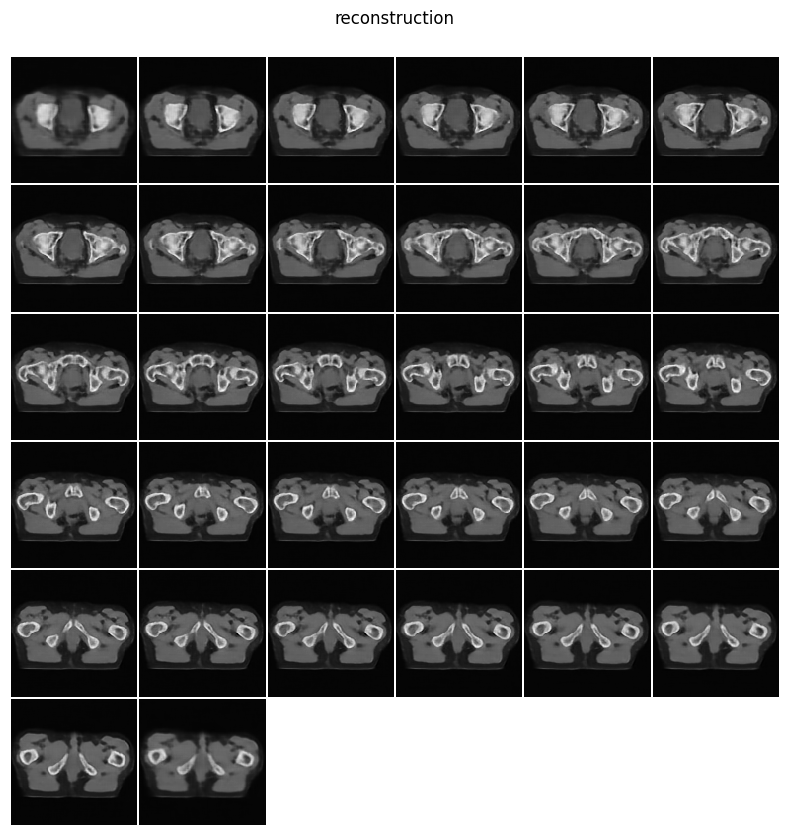

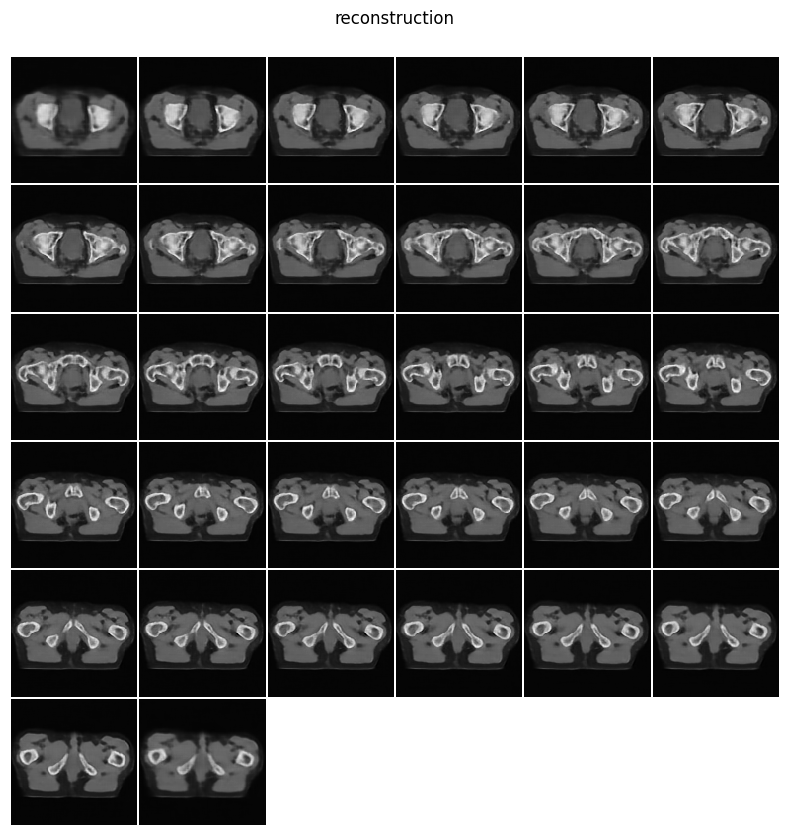

In [203]:
plot_dicom(x_recon, "reconstruction")
# plt.savefig("../reports/meta_autoenc_reconstruction_full.png")

In [166]:
from src.utils import calculate_common_metrics

In [167]:
first(train_loader).shape

torch.Size([1, 1, 128, 128, 32])

In [168]:
metrics = {
    "L2": 0,
    "L1": 0,
    "ssim": 0,
    "lpips": 0,
}
for batch in train_loader:
    with torch.no_grad():
        # x = dicom_batch_to_video_batch(batch).to(device)
        reconstruction, z_mu, z_sigma = vae.forward(batch.as_tensor().to(device))
        # x_recon = video_batch_to_dicom_batch(re)
        current_metrics = calculate_common_metrics(batch.to(device), reconstruction.to(device))
        for k, v in current_metrics.items():
            metrics[k] += v

for k, v in metrics.items():
    metrics[k] = v / len(train_loader)

Setting up [baseline] perceptual loss: trunk [vgg], v[0.1], spatial [off]


/home/gormat/Documents/ct-images-augmentation/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Setting up [baseline] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Setting up [baseline] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Setting up [baseline] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Setting up [baseline] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Setting up [baseline] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Setting up [baseline] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Setting up [baseline] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Setting up [baseline] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Setting up [baseline] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Setting up [baseline] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Setting up [baseline] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Setting up [baseline] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Setting up [baseline] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Setting up [baseline] perceptual loss:

In [169]:
metrics

{'L2': metatensor(0.0043, device='cuda:0'),
 'L1': metatensor(0.0309, device='cuda:0'),
 'ssim': metatensor(0.8690, device='cuda:0'),
 'lpips': metatensor([[[[[2.2485]]]]], device='cuda:0')}

```json
{'L2': metatensor(0.0044, device='cuda:0'),
 'L1': metatensor(0.0310, device='cuda:0'),
 'ssim': metatensor(0.8676, device='cuda:0'),
 'lpips': metatensor([[[[[2.2557]]]]], device='cuda:0')}
```

In [1]:
from src.utils import make_comparison

/home/gormat/Documents/ct-images-augmentation/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [213]:
comp = make_comparison(batch.to(device), x_recon.to(device)).cpu()

In [214]:
from torchvision.utils import make_grid

In [215]:
comp2 = make_grid(comp, nrow=32, normalize=True).permute(1, 2, 0)

In [205]:
import matplotlib.image as mpimg

In [217]:
mpimg.imsave("../reports/monai_autoenc_comparison_full.png", comp2.numpy())

In [ ]:
grid = make_grid(comp, nrow=32, normalize=True)